# Setup

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt


In [201]:
from datetime import datetime

def toDate(ts):
    return datetime.fromtimestamp(float(ts)).date()

np.random.seed(7)

# Load the data

In [143]:
df = pd.read_csv("~/data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27.csv", parse_dates=True, date_parser=toDate, index_col="Timestamp")
df.index.names = ["Date"]
df['Volume'] = pd.to_numeric(df['Volume_(Currency)'])

df.shape


1304.0


(1819074, 8)

# Preprocess the data

In [146]:
historical_prices = df.resample('1D').agg({'Open': 'first', 
                                 'High': 'max', 
                                 'Low': 'min', 
                                 'Close': 'last',
                                 'Volume': 'sum'}).dropna()
historical_prices = historical_prices[['Close', 'Volume']]

number_of_days = historical_prices.shape[0]
print(number_of_days)

historical_prices.shape

1271


(1271, 2)

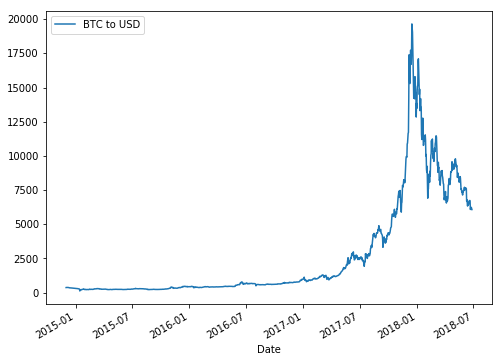

In [147]:
historical_prices.reset_index().plot(x="Date", y="Close", figsize=(8, 6), label="BTC to USD")

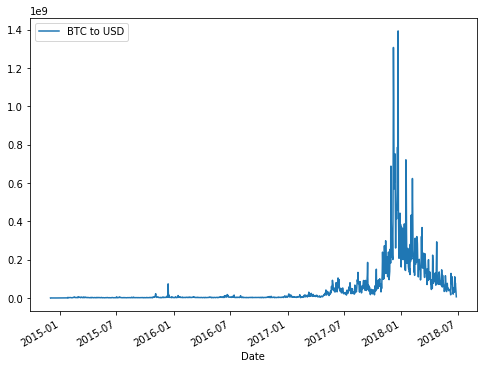

In [148]:
historical_prices.reset_index().plot(x="Date", y="Volume", figsize=(8, 6), label="BTC to USD")

# Split the dataset into training and testing set

In [177]:
from sklearn.model_selection import train_test_split

test_split_point = int(number_of_days * 0.8)
train = historical_prices[:test_split_point]
test = historical_prices[test_split_point:]

In [178]:
train.shape

(1016, 2)

In [179]:
test.shape

(255, 2)

# Train model

In [180]:
train = train.sort_values(by='Date')
test = test.sort_values(by='Date')

In [181]:
window_len = 10
LSTM_training_inputs = []
norm_cols = ["Close", "Volume"]

for i in range(len(train)-window_len):
    temp_set = train[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

LSTM_training_outputs = (train['Close'][window_len:].values/train['Close'][:-window_len].values)-1

In [182]:
LSTM_test_inputs = []
for i in range(len(test)-window_len):
    temp_set = test[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = (test['Close'][window_len:].values/test['Close'][:-window_len].values)-1

In [183]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [184]:
model = Sequential()

model.add(LSTM(20, input_shape=(LSTM_training_inputs.shape[1], LSTM_training_inputs.shape[2])))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.add(Activation("linear"))

model.compile(loss="mae", optimizer="adam")

In [185]:
history = model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 13s - loss: 0.0608
Epoch 2/50
 - 13s - loss: 0.0411
Epoch 3/50
 - 13s - loss: 0.0367
Epoch 4/50
 - 13s - loss: 0.0342
Epoch 5/50
 - 15s - loss: 0.0317
Epoch 6/50
 - 14s - loss: 0.0314
Epoch 7/50
 - 14s - loss: 0.0307
Epoch 8/50
 - 14s - loss: 0.0304
Epoch 9/50
 - 13s - loss: 0.0296
Epoch 10/50
 - 13s - loss: 0.0289
Epoch 11/50
 - 14s - loss: 0.0292
Epoch 12/50
 - 14s - loss: 0.0284
Epoch 13/50
 - 13s - loss: 0.0281
Epoch 14/50
 - 13s - loss: 0.0287
Epoch 15/50
 - 13s - loss: 0.0282
Epoch 16/50
 - 13s - loss: 0.0281
Epoch 17/50
 - 14s - loss: 0.0280
Epoch 18/50
 - 13s - loss: 0.0275
Epoch 19/50
 - 13s - loss: 0.0284
Epoch 20/50
 - 13s - loss: 0.0274
Epoch 21/50
 - 13s - loss: 0.0286
Epoch 22/50
 - 13s - loss: 0.0276
Epoch 23/50
 - 13s - loss: 0.0273
Epoch 24/50
 - 13s - loss: 0.0271
Epoch 25/50
 - 13s - loss: 0.0272
Epoch 26/50
 - 13s - loss: 0.0277
Epoch 27/50
 - 13s - loss: 0.0288
Epoch 28/50
 - 13s - loss: 0.0283
Epoch 29/50
 - 13s - loss: 0.0277
Epoch 30/50
 - 13s - lo

In [186]:
mae = np.mean(np.abs((np.transpose(model.predict(LSTM_test_inputs))+1)-\
            (test['Close'].values[window_len:])/(test['Close'].values[:-window_len]))) 

mae

0.041315016262840225

In [199]:
LSTM_test_inputs[0]

array([[ 0.00000000e+00,  0.00000000e+00],
       [-2.54596468e-02,  3.65031905e-02],
       [-2.25542209e-02,  8.78923640e-01],
       [-9.06087051e-04,  6.04513582e-02],
       [ 4.76150494e-02,  9.40726785e-01],
       [ 6.54884037e-02,  7.94697101e-01],
       [ 3.84877092e-02,  2.61634730e-01],
       [ 2.64829304e-02,  9.10754599e-01],
       [-3.65373481e-02,  1.06530963e+00],
       [-4.52518765e-03,  5.46404624e-01]])

In [187]:
predicted = np.transpose(model.predict(LSTM_test_inputs)) + 1

In [188]:
actual = (test['Close'].values[window_len:])/(test['Close'].values[:-window_len])

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:504: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


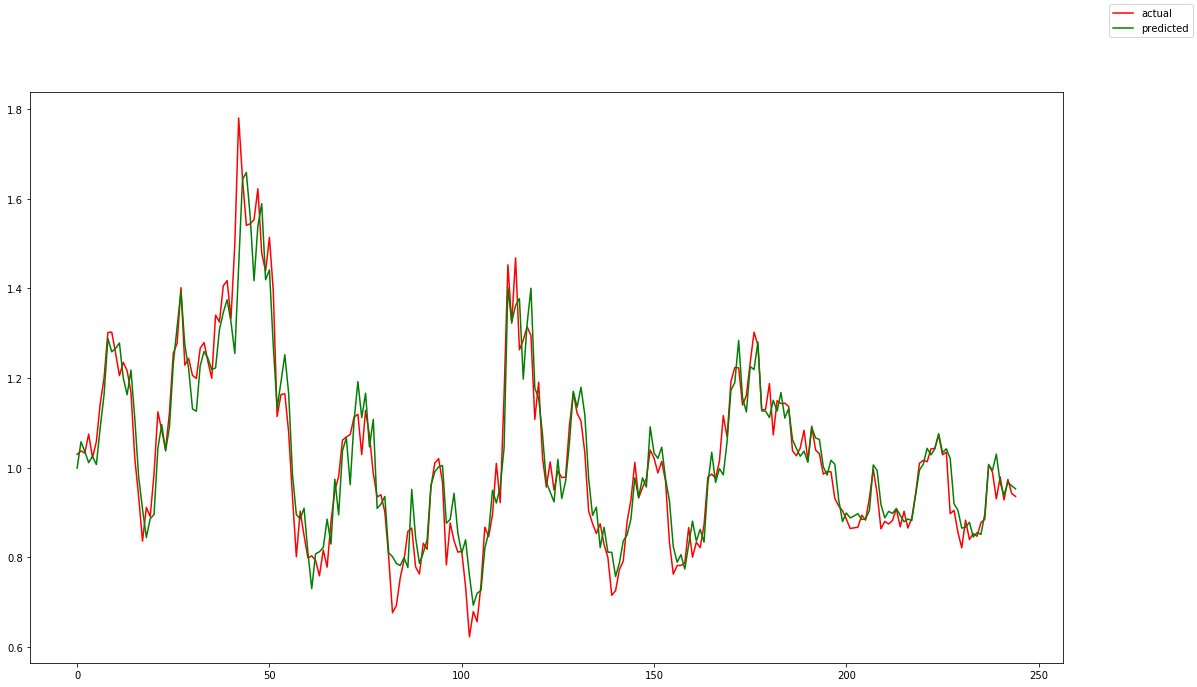

In [189]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)
ax1.plot(actual, label="actual", color="red")
ax1.plot(predicted[0], label="predicted", color="green")
fig.legend(loc="best")
plt.show()

In [206]:
rmae = np.sqrt(((predicted-actual) ** 2).mean())

rmae

0.05796879663253971

In [193]:
predicted2 = (np.transpose(model.predict(LSTM_test_inputs)) + 1) * (test['Close'].values[:-window_len])

In [194]:
actual2 = (test['Close'].values[window_len:])

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:504: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


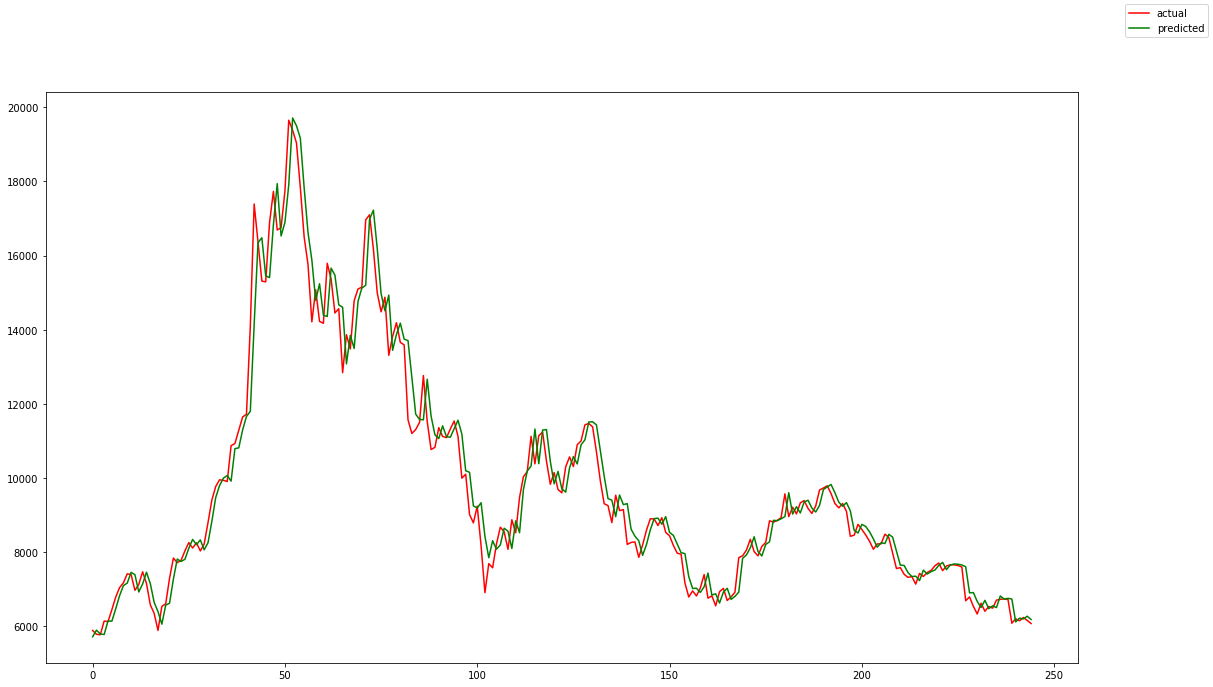

In [195]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)
ax1.plot(actual2, label="actual", color="red")
ax1.plot(predicted2[0], label="predicted", color="green")
fig.legend(loc="best")
plt.show()

In [205]:
rmae = np.sqrt(((predicted2-actual2) ** 2).mean())

rmae

623.6942738169943